In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Problem definition

Context

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.

This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

Attribute Information

1) id: unique identifier

2) gender: "Male", "Female" or "Other"

3) age: age of the patient

4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

6) ever_married: "No" or "Yes"

7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

8) Residence_type: "Rural" or "Urban"

9) avg_glucose_level: average glucose level in blood

10) bmi: body mass index

11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*

12) stroke: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

Acknowledgements (Confidential Source) - Use only for educational purposes If you use this dataset in your research, please credit the author.

# Libraries

Let us import necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, roc_auc_score, auc, roc_curve, average_precision_score, precision_recall_curve
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, log_loss, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif,f_regression,mutual_info_regression
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.impute import SimpleImputer
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.cluster import KElbowVisualizer

import missingno as msno

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.7f' % x)

# User Defined Functions

In [2]:
# For checking missing values and missing percent

def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

In [3]:
# To view summary information about the column

def first_looking(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))

# Data Gathering
- Read the csv

In [4]:
#df = pd.read_csv("../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")

In [102]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [103]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0000000,0,1,Yes,Private,Urban,228.6900000,36.6000000,formerly smoked,1
1,51676,Female,61.0000000,0,0,Yes,Self-employed,Rural,202.2100000,NaN,never smoked,1
2,31112,Male,80.0000000,0,1,Yes,Private,Rural,105.9200000,32.5000000,never smoked,1
3,60182,Female,49.0000000,0,0,Yes,Private,Urban,171.2300000,34.4000000,smokes,1
4,1665,Female,79.0000000,1,0,Yes,Self-employed,Rural,174.1200000,24.0000000,never smoked,1


# Data Preparation
- Get basic information from the dataset

Let's start by standardizing all column names.

In [104]:
df.columns = df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

In [105]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [106]:
df.shape

(5110, 12)

In [107]:
print (f' We have {df.shape[0]} instances with the {df.shape[1]-1} features and 1 target variable.')

 We have 5110 instances with the 11 features and 1 target variable.


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


- We have both numerical and categorical variables (8 numerical, 4 categorical).
- The most important column is our target variable "stroke".
- Target variable is coded as **1** for positive cases and **0** for negative cases.
- "Hypertension" and "heart disease" columns are coded like "stroke" column.

In [109]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0000000,36517.8293542,21161.7216248,67.0000000,17741.2500000,36932.0000000,54682.0000000,72940.0000000
age,5110.0000000,43.2266145,22.6126467,0.0800000,25.0000000,45.0000000,61.0000000,82.0000000
hypertension,5110.0000000,0.0974560,0.2966067,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000
heart_disease,5110.0000000,0.0540117,0.2260630,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000
avg_glucose_level,5110.0000000,106.1476771,45.2835602,55.1200000,77.2450000,91.8850000,114.0900000,271.7400000
bmi,4909.0000000,28.8932369,7.8540667,10.3000000,23.5000000,28.1000000,33.1000000,97.6000000
stroke,5110.0000000,0.0487280,0.2153199,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000


- An overview of the values each column contains. Above we can see some basic descriptive statistics for all numeric columns.

In [110]:
df.describe(include=object).T

,count,unique,top,freq
gender,5110,3,Female,2994
ever_married,5110,2,Yes,3353
work_type,5110,5,Private,2925
residence_type,5110,2,Urban,2596
smoking_status,5110,4,never smoked,1892


- We can also analyze other data types. But we can not calculate a mean or a standard deviation for the object columns. However, it will still display some descriptive statistics

In [111]:
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

- Number of unique values in each column

In [112]:
df.duplicated().value_counts()

False    5110
dtype: int64

- There is no dublicated value in the dataset

In [113]:
missing (df)

,Missing_Number,Missing_Percent
bmi,201,0.0393346
id,0,0.0000000
gender,0,0.0000000
age,0,0.0000000
hypertension,0,0.0000000
heart_disease,0,0.0000000
ever_married,0,0.0000000
work_type,0,0.0000000
residence_type,0,0.0000000
avg_glucose_level,0,0.0000000


- Only the "bmi" column has 201 null values. We will fill in these values while defining X and y before modelling.

### Data Cleaning

In "id" column, all the values are unique. Let's drop the "id" column.

In [114]:
df.drop('id', axis=1, inplace=True)

In [115]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

- Before deeping into the analysis it would be benefical to examine the correlation among variables using heatmap.

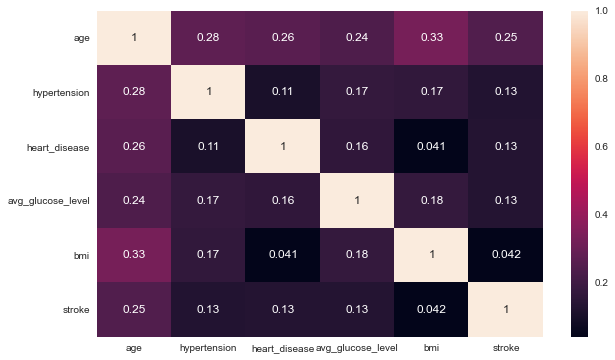

In [116]:
sns.heatmap(df.corr(), annot=True);

- Let's split our features into two part, numerical and categorical, for easing our further examination.

In [117]:
numerical= df.drop(['stroke'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')


Categorical Columns: Index(['gender', 'ever_married', 'work_type', 'residence_type',
       'smoking_status'],
      dtype='object')


### The Examination of Target Variable

In [118]:
first_looking("stroke")

column name    :  stroke
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
0    4861
1     249
Name: stroke, dtype: int64


In [119]:
df['stroke'].describe()

count   5110.0000000
mean       0.0487280
std        0.2153199
min        0.0000000
25%        0.0000000
50%        0.0000000
75%        0.0000000
max        1.0000000
Name: stroke, dtype: float64

In [120]:
print( f"Skewness: {df['stroke'].skew()}")

Skewness: 4.193284486071313


In [121]:
df['stroke'].iplot(kind='hist')

- "stroke" column is coded as **1** for positive cases (has a stroke) and **0** for negative cases (does not have a stroke).
- Approximately % 95 of our target variable is 'No stroke' (4861)
- %5 of the instances of our target variable is 'Stroke' (249)

### Numerical Features

In [122]:
df[numerical].head().T

,0,1,2,3,4
age,67.0000000,61.0000000,80.0000000,49.0000000,79.0000000
hypertension,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000
heart_disease,1.0000000,0.0000000,1.0000000,0.0000000,0.0000000
avg_glucose_level,228.6900000,202.2100000,105.9200000,171.2300000,174.1200000
bmi,36.6000000,NaN,32.5000000,34.4000000,24.0000000


In [123]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
age,5110.0000000,43.2266145,22.6126467,0.0800000,25.0000000,45.0000000,61.0000000,82.0000000
hypertension,5110.0000000,0.0974560,0.2966067,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000
heart_disease,5110.0000000,0.0540117,0.2260630,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000
avg_glucose_level,5110.0000000,106.1476771,45.2835602,55.1200000,77.2450000,91.8850000,114.0900000,271.7400000
bmi,4909.0000000,28.8932369,7.8540667,10.3000000,23.5000000,28.1000000,33.1000000,97.6000000


In [124]:
df[numerical].iplot(kind='hist');

In [125]:
df[numerical].iplot(kind='histogram',subplots=True,bins=50)

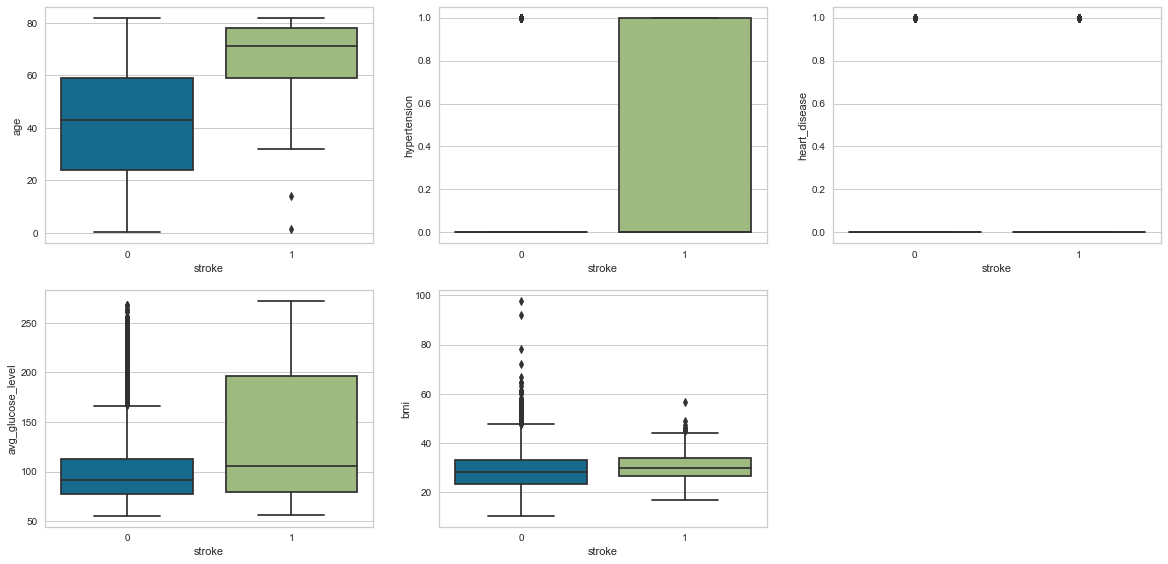

In [126]:
index = 0
plt.figure(figsize=(20,20))
for feature in numerical:
    if feature != "stroke":
        index += 1
        plt.subplot(4,3,index)
        sns.boxplot(x='stroke',y=feature,data=df)

In [127]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models. 
skew_vals = df[numerical].skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols 

heart_disease       3.9472440
hypertension        2.7153917
avg_glucose_level   1.5722839
bmi                 1.0553402
dtype: float64

In [128]:
df[skew_cols.index].iplot(kind='hist');

In [129]:
df[skew_cols.index].iplot(kind='histogram',subplots=True,bins=50)

- Some features have skewness. Let's try to handle with their skewness by "np.log" and "PowerTransformer".

### Handling with Skewness

In [130]:
# skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models.
# skew_vals = df[numerical].skew()
# skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
# skew_cols = skew_cols.drop(['heart_disease', 'hypertension'])
# skew_cols

**With np.log**

In [131]:
# df_try = df.copy()
# df_try = df[skew_cols.index].copy()
# for col in skew_cols.index.values:
#     df_try[col] = df_try[col].apply(np.log1p)
# print(df_try[skew_cols.index].skew())
# print()
# df_try[skew_cols.index].iplot(kind='histogram',subplots=True,bins=50);

**With Power Transformer**

In [132]:
# df_trans = df[skew_cols.index].copy()
# pt = PowerTransformer(method='yeo-johnson')
# trans= pt.fit_transform(df_trans)
# df_trans = pd.DataFrame(trans, columns =skew_cols.index )
# print(df_trans.skew())
# print()
# df_trans.iplot(kind='histogram',subplots=True,bins=50);

In [133]:
# df_trans.columns

In [134]:
df.shape

(5110, 11)

In [135]:
# df.drop(['avg_glucose_level', 'bmi'], axis=1, inplace=True)

In [136]:
df.shape

(5110, 11)

In [137]:
# df = pd.concat([df, df_trans], axis=1)

In [138]:
df.shape

(5110, 11)

In [139]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [140]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. 
                  # Overall below abs(1) seems acceptable for the linear models.
skew_vals = df[numerical].skew()
skew_cols= skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols

heart_disease       3.9472440
hypertension        2.7153917
avg_glucose_level   1.5722839
bmi                 1.0553402
dtype: float64

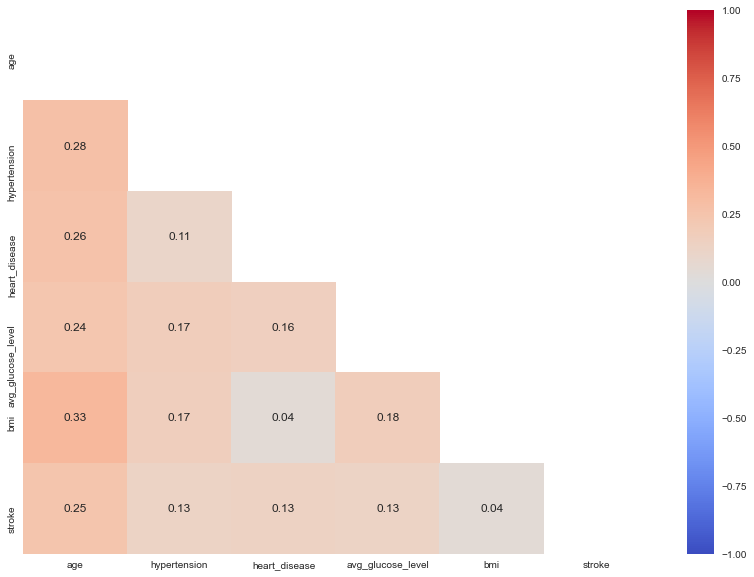

In [141]:
numerical= df.select_dtypes('number').columns

matrix = np.triu(df[numerical].corr())
fig, ax = plt.subplots(figsize=(14,10)) 
sns.heatmap (df[numerical].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax);

In [142]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0000000,0,1,Yes,Private,Urban,228.6900000,36.6000000,formerly smoked,1
1,Female,61.0000000,0,0,Yes,Self-employed,Rural,202.2100000,NaN,never smoked,1
2,Male,80.0000000,0,1,Yes,Private,Rural,105.9200000,32.5000000,never smoked,1
3,Female,49.0000000,0,0,Yes,Private,Urban,171.2300000,34.4000000,smokes,1
4,Female,79.0000000,1,0,Yes,Self-employed,Rural,174.1200000,24.0000000,never smoked,1


In [143]:
first_looking("age")

column name    :  age
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  104
78.0000000    102
57.0000000     95
52.0000000     90
54.0000000     87
51.0000000     86
79.0000000     85
53.0000000     85
45.0000000     85
50.0000000     83
55.0000000     83
59.0000000     80
31.0000000     79
49.0000000     79
56.0000000     77
37.0000000     76
61.0000000     76
44.0000000     75
47.0000000     75
63.0000000     74
62.0000000     74
40.0000000     74
41.0000000     73
38.0000000     72
60.0000000     72
42.0000000     71
39.0000000     71
32.0000000     71
80.0000000     70
43.0000000     70
34.0000000     68
58.0000000     68
48.0000000     66
5.0000000      65
23.0000000     64
65.0000000     62
46.0000000     62
26.0000000     62
71.0000000     61
81.0000000     60
66.0000000     60
17.0000000     60
18.0000000     60
20.0000000     59
8.0000000      58
25.0000000     57
33.0000000     57
13.0000000     57
82.0000000     56
27.0000000     

In [144]:
df = df[df['age'] >= 14]

In [145]:
first_looking("hypertension")

column name    :  hypertension
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
0    3967
1     498
Name: hypertension, dtype: int64


In [146]:
first_looking("heart_disease")

column name    :  heart_disease
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
0    4190
1     275
Name: heart_disease, dtype: int64


In [147]:
first_looking("avg_glucose_level")

column name    :  avg_glucose_level
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  3618
91.8500000     5
73.0000000     5
91.6800000     5
92.8200000     4
81.5100000     4
              ..
100.0100000    1
202.6700000    1
87.9100000     1
71.3400000     1
60.5000000     1
Name: avg_glucose_level, Length: 3618, dtype: int64


In [148]:
first_looking("bmi")

column name    :  bmi
--------------------------------
per_of_nulls   :  % 4.14
num_of_nulls   :  185
num_of_uniques :  383
NaN           185
28.7000000     40
28.4000000     38
27.7000000     36
27.0000000     35
27.6000000     35
26.7000000     35
26.1000000     35
27.3000000     35
26.4000000     34
26.9000000     34
25.1000000     33
25.5000000     31
23.4000000     30
31.4000000     30
28.9000000     30
30.3000000     30
28.1000000     29
29.4000000     29
22.2000000     29
26.5000000     29
28.3000000     29
26.6000000     29
27.5000000     28
29.1000000     28
24.2000000     28
24.1000000     28
28.0000000     27
27.1000000     27
26.2000000     27
30.9000000     27
30.0000000     27
25.0000000     27
31.5000000     27
24.8000000     27
27.9000000     27
23.5000000     27
32.3000000     27
29.7000000     26
28.5000000     26
24.9000000     26
30.1000000     26
29.6000000     26
29.2000000     26
29.5000000     26
25.3000000     26
29.0000000     26
28.6000000     26
31.1000000  

### Categorical Features

In [149]:
df[categorical].head().T

,0,1,2,3,4
gender,Male,Female,Male,Female,Female
ever_married,Yes,Yes,Yes,Yes,Yes
work_type,Private,Self-employed,Private,Private,Self-employed
residence_type,Urban,Rural,Rural,Urban,Rural
smoking_status,formerly smoked,never smoked,never smoked,smokes,never smoked


In [150]:
df[categorical].describe().T

,count,unique,top,freq
gender,4465,3,Female,2690
ever_married,4465,2,Yes,3353
work_type,4465,5,Private,2915
residence_type,4465,2,Urban,2268
smoking_status,4465,4,never smoked,1847


### gender & stroke

In [151]:
first_looking("gender")

column name    :  gender
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  3
Female    2690
Male      1774
Other        1
Name: gender, dtype: int64


- We have 3 unique values. It seems that the "other" value is entered incorrectly. So let's drop it.

In [152]:
df.drop(df[df['gender'] == 'Other'].index, inplace = True)

In [153]:
df['gender'].value_counts()

Female    2690
Male      1774
Name: gender, dtype: int64

In [154]:
print(df.groupby('gender')['stroke'].mean().sort_values())
print()
df.groupby('gender')['stroke'].mean().iplot(kind='histogram',subplots=True,bins=50)

gender
Female   0.0520446
Male     0.0608794
Name: stroke, dtype: float64



### ever_married & stroke

In [155]:
first_looking("ever_married")

column name    :  ever_married
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
Yes    3353
No     1111
Name: ever_married, dtype: int64


In [156]:
print(df.groupby('ever_married')['stroke'].mean().sort_values())
print()
df.groupby('ever_married')['stroke'].mean().iplot(kind='histogram',subplots=True,bins=50)

ever_married
No    0.0252025
Yes   0.0656129
Name: stroke, dtype: float64



### work_type & stroke

In [157]:
first_looking("work_type")

column name    :  work_type
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  5
Private          2914
Self-employed     817
Govt_job          657
children           57
Never_worked       19
Name: work_type, dtype: int64


In [158]:
print(df.groupby('work_type')['stroke'].mean().sort_values())
print()
df.groupby('work_type')['stroke'].mean().iplot(kind='histogram',subplots=True,bins=50)

work_type
Never_worked    0.0000000
children        0.0175439
Govt_job        0.0502283
Private         0.0511325
Self-employed   0.0795594
Name: stroke, dtype: float64



### residence_type & stroke

In [159]:
first_looking("residence_type")

column name    :  residence_type
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
Urban    2268
Rural    2196
Name: residence_type, dtype: int64


In [160]:
print(df.groupby('residence_type')['stroke'].mean().sort_values())
print()
df.groupby('residence_type')['stroke'].mean().iplot(kind='histogram',subplots=True,bins=50)

residence_type
Rural   0.0519126
Urban   0.0590829
Name: stroke, dtype: float64



### smoking_status & stroke

In [161]:
first_looking("smoking_status")

column name    :  smoking_status
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  4
never smoked       1847
Unknown             959
formerly smoked     872
smokes              786
Name: smoking_status, dtype: int64


In [162]:
print(df.groupby('smoking_status')['stroke'].mean().sort_values())
print()
df.groupby('smoking_status')['stroke'].mean().iplot(kind='histogram',subplots=True,bins=50)

smoking_status
Unknown           0.0479666
never smoked      0.0487277
smokes            0.0534351
formerly smoked   0.0802752
Name: stroke, dtype: float64



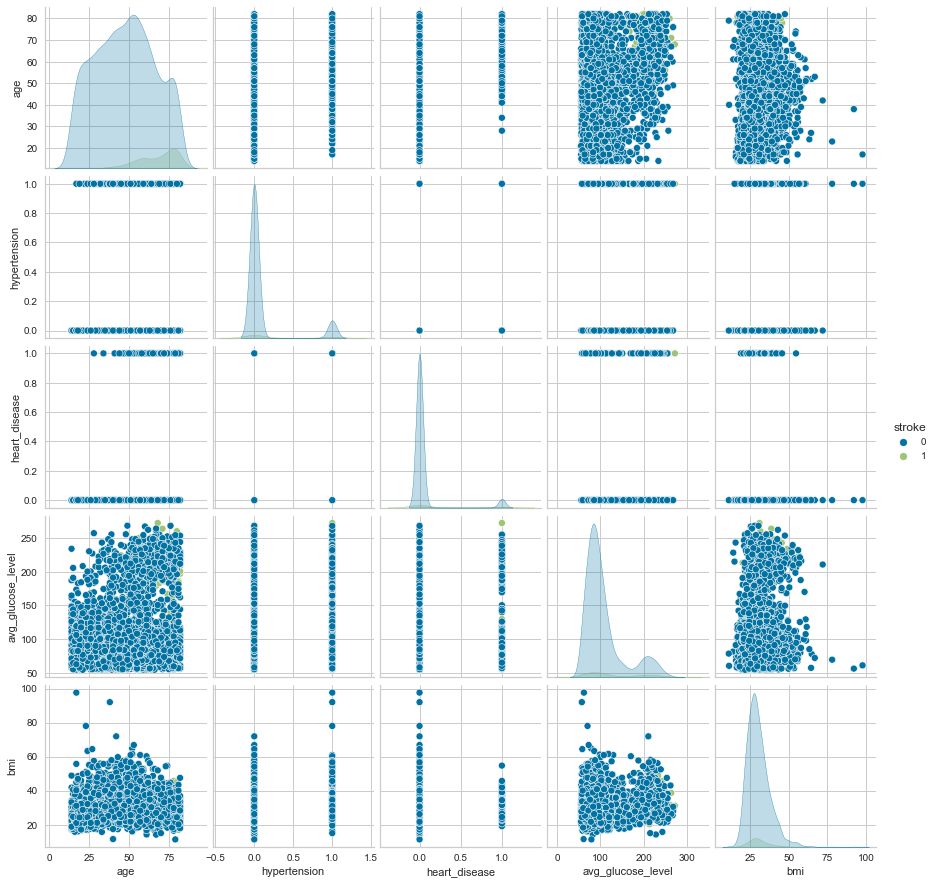

In [163]:
sns.pairplot(df, hue="stroke");

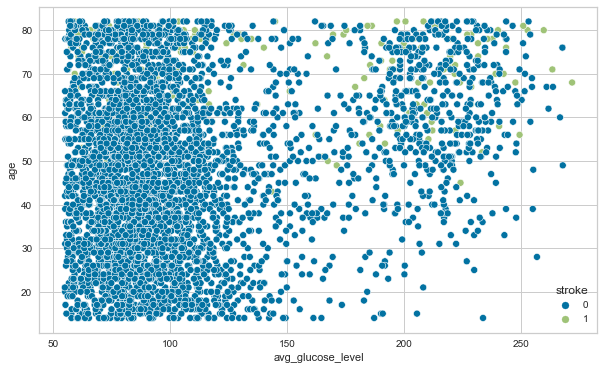

In [164]:
sns.scatterplot(x = 'avg_glucose_level', y = 'age', hue = 'stroke', data = df);

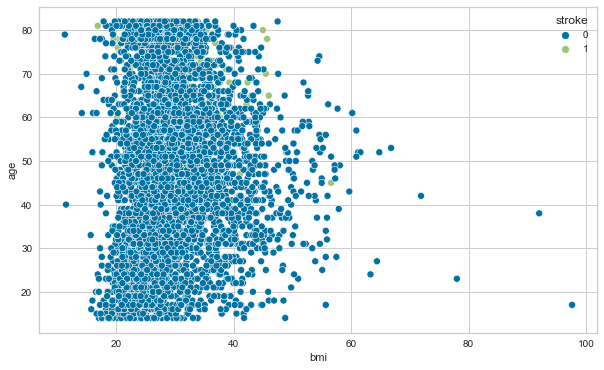

In [165]:
sns.scatterplot(x = 'bmi', y = 'age', hue = 'stroke', data = df);

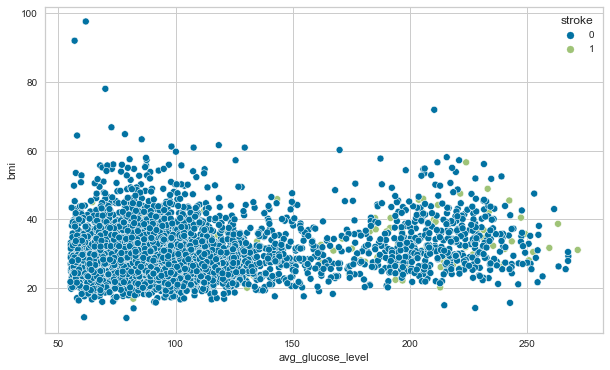

In [166]:
sns.scatterplot(x = 'avg_glucose_level', y = 'bmi', hue = 'stroke', data = df);

# Dummy Operations

In [167]:
df = pd.get_dummies(df, columns=['gender', 'ever_married',
       'work_type', 'residence_type', 'smoking_status',], drop_first=True)

In [168]:
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0000000,0,1,228.6900000,36.6000000,1,1,1,0,1,0,0,1,1,0,0
1,61.0000000,0,0,202.2100000,NaN,1,0,1,0,0,1,0,0,0,1,0
2,80.0000000,0,1,105.9200000,32.5000000,1,1,1,0,1,0,0,0,0,1,0
3,49.0000000,0,0,171.2300000,34.4000000,1,0,1,0,1,0,0,1,0,0,1
4,79.0000000,1,0,174.1200000,24.0000000,1,0,1,0,0,1,0,0,0,1,0


<AxesSubplot:>

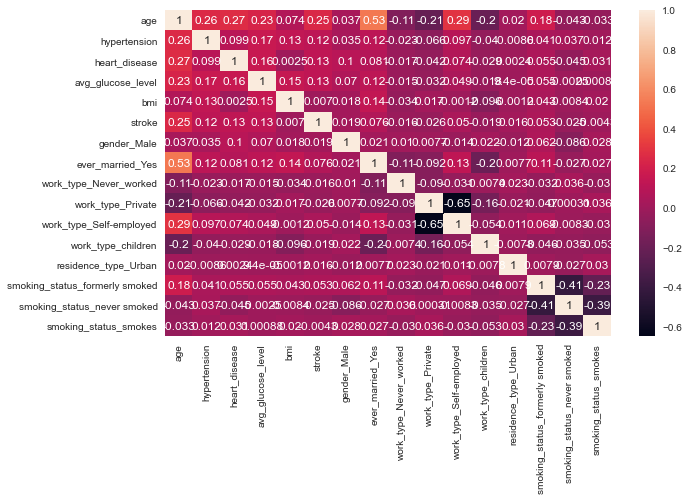

In [169]:
sns.heatmap(df.corr(), annot=True)

# Data Preprocessing

In [170]:
X = df.drop('stroke',axis=1)
y = df['stroke']

### Train / Test and Split

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Filling the Missing Values

In [172]:
X_train.bmi.value_counts(dropna=False)

NaN           122
28.4000000     26
26.7000000     25
27.3000000     25
26.9000000     25
26.4000000     24
28.9000000     24
27.6000000     24
26.1000000     24
25.1000000     23
31.4000000     23
30.3000000     23
24.2000000     23
27.0000000     23
28.7000000     22
27.7000000     22
25.0000000     22
28.1000000     22
23.5000000     22
25.5000000     22
24.0000000     21
27.2000000     21
28.3000000     21
29.1000000     21
30.9000000     21
23.4000000     20
24.9000000     20
28.0000000     20
26.6000000     20
32.3000000     20
24.5000000     19
25.3000000     19
25.6000000     19
29.4000000     19
29.6000000     19
35.8000000     19
29.9000000     19
27.9000000     19
29.7000000     19
27.8000000     19
30.0000000     19
25.9000000     18
26.5000000     18
26.3000000     18
24.8000000     18
26.2000000     18
23.0000000     18
31.5000000     18
32.0000000     18
32.1000000     18
30.5000000     18
30.1000000     18
25.4000000     18
27.1000000     17
28.2000000     17
22.8000000

In [173]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median")

X_train['bmi'] = imputer.fit_transform(X_train['bmi'].values.reshape(-1,1))[:,0]

In [174]:
X_test['bmi'] = imputer.fit_transform(X_test['bmi'].values.reshape(-1,1))[:,0]

- We imputed train and test sets seperately so that we did not have data leakage.

In [175]:
print(X_train.isnull().sum())

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
gender_Male                       0
ever_married_Yes                  0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
residence_type_Urban              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64


In [176]:
print(X_test.isnull().sum())

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
gender_Male                       0
ever_married_Yes                  0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
residence_type_Urban              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64


### Scaling

In [177]:
scaler = MinMaxScaler()
scaler

MinMaxScaler()

In [178]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Implement Logistic Regression and Evaluate

print(confusion_matrix(y_test,log_pred2))
print(classification_report(y_test,log_pred2))

In [179]:
log_model=LogisticRegression(class_weight = "balanced")

In [180]:
log_model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced')

In [181]:
log_pred = log_model.predict(X_test_scaled)

In [182]:
log_pred_proba = log_model.predict_proba(X_test_scaled)

In [183]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data["pred"] = log_pred
test_data["pred_proba"] = log_pred_proba[:,1]
test_data.sample(10)

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke,pred,pred_proba
342,34.0000000,0,1,106.2300000,28.8000000,1,1,0,1,0,0,1,1,0,0,0,0,0.1982171
4658,55.0000000,0,0,99.4400000,25.0000000,0,1,0,0,0,0,1,1,0,0,0,0,0.4480726
1178,59.0000000,0,0,226.1100000,32.8000000,0,1,0,1,0,0,0,1,0,0,0,1,0.5666846
3021,79.0000000,0,0,103.2100000,22.9000000,1,1,0,0,1,0,0,1,0,0,0,1,0.7605085
4987,64.0000000,1,0,196.2600000,34.5000000,1,1,0,1,0,0,0,0,0,0,0,1,0.7404583
1584,32.0000000,0,0,97.1400000,55.9000000,0,1,0,1,0,0,1,0,1,0,0,0,0.0999983
4594,16.0000000,0,0,84.1000000,19.3000000,1,0,0,1,0,0,1,0,0,0,0,0,0.0479882
1674,65.0000000,0,0,82.2600000,19.8000000,0,1,0,1,0,0,1,1,0,0,0,1,0.6250322
1961,53.0000000,0,0,84.8500000,24.7000000,0,1,0,0,1,0,1,0,1,0,0,0,0.3062702
4389,41.0000000,0,0,76.3400000,28.0000000,0,1,0,1,0,0,1,0,0,0,0,0,0.2061644


### Model Performance on Classification Tasks

In [184]:
print(confusion_matrix(y_test, log_pred))
print(classification_report(y_test, log_pred))

[[888 371]
 [ 14  67]]
              precision    recall  f1-score   support

           0       0.98      0.71      0.82      1259
           1       0.15      0.83      0.26        81

    accuracy                           0.71      1340
   macro avg       0.57      0.77      0.54      1340
weighted avg       0.93      0.71      0.79      1340



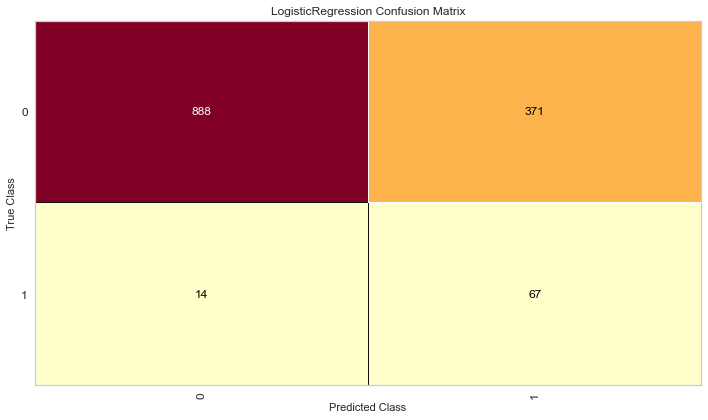

In [185]:
cm = ConfusionMatrix(log_model)
cm.fit(X_train_scaled, y_train)
cm.score(X_test_scaled, y_test)
cm.show();

### Cross Validate

In [186]:
model = LogisticRegression(class_weight = "balanced")
model

LogisticRegression(class_weight='balanced')

In [187]:
scores = cross_validate(model, X_train_scaled, y_train, scoring = ['accuracy', 'precision','recall','f1'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
#df_scores
df_scores.mean()[2:]

test_accuracy    0.7327046
test_precision   0.1365048
test_recall      0.7496324
test_f1          0.2308444
dtype: float64

### ROC (Receiver Operating Curve) and AUC (Area Under Curve)

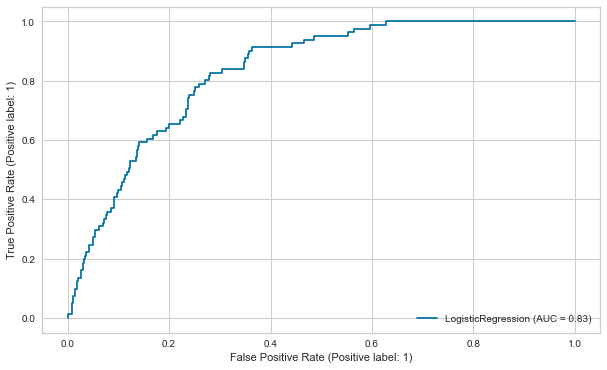

In [188]:
plot_roc_curve(log_model, X_test_scaled, y_test);

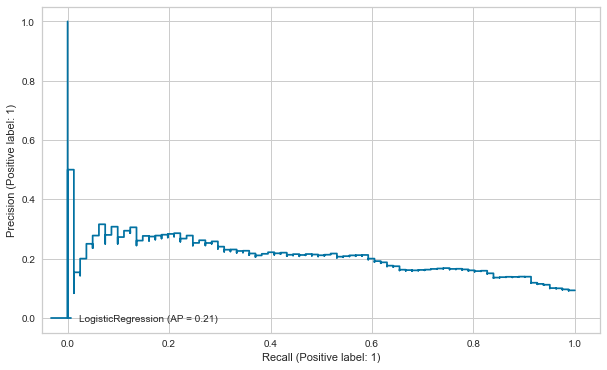

In [189]:
plot_precision_recall_curve(log_model, X_test_scaled, y_test);

### Finding Best Threshold

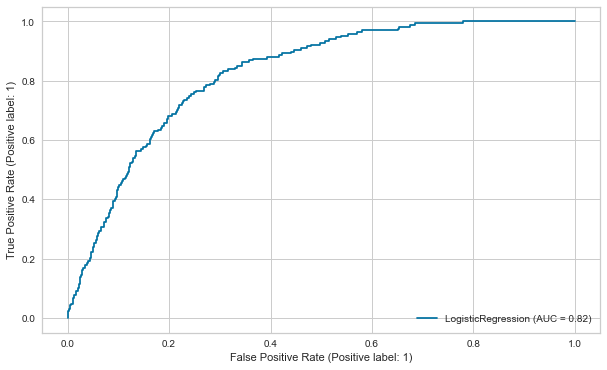

In [190]:
plot_roc_curve(log_model, X_train_scaled, y_train);

In [191]:
log_pred_proba = log_model.predict_proba(X_train_scaled)
roc_auc_score(y_train, log_pred_proba[:,1])

0.8232753296248221

In [192]:
fp_rate, tp_rate, thresholds = roc_curve(y_train, log_pred_proba[:,1])

In [193]:
optimal_idx = np.argmax(tp_rate - fp_rate)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.4575763585572521

In [194]:
test_data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke,pred,pred_proba
303,66.0000000,0,0,242.3000000,35.3000000,1,1,0,1,0,0,0,0,0,1,0,1,0.6625034
1065,67.0000000,0,0,67.7900000,26.0000000,1,1,0,0,0,0,1,1,0,0,0,1,0.6128974
2307,49.0000000,0,0,220.4700000,36.4000000,1,1,0,0,1,0,0,0,0,1,0,0,0.3359242
644,43.0000000,0,0,98.0900000,17.3000000,0,1,0,0,1,0,1,0,1,0,0,0,0.1843986
3891,77.0000000,0,0,57.6000000,32.2000000,1,1,0,0,1,0,1,0,0,0,0,1,0.7264341


In [195]:
test_data["pred2"] = test_data["pred_proba"].apply(lambda x : 1 if x >= optimal_threshold else 0)

In [196]:
test_data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke,pred,pred_proba,pred2
303,66.0000000,0,0,242.3000000,35.3000000,1,1,0,1,0,0,0,0,0,1,0,1,0.6625034,1
1065,67.0000000,0,0,67.7900000,26.0000000,1,1,0,0,0,0,1,1,0,0,0,1,0.6128974,1
2307,49.0000000,0,0,220.4700000,36.4000000,1,1,0,0,1,0,0,0,0,1,0,0,0.3359242,0
644,43.0000000,0,0,98.0900000,17.3000000,0,1,0,0,1,0,1,0,1,0,0,0,0.1843986,0
3891,77.0000000,0,0,57.6000000,32.2000000,1,1,0,0,1,0,1,0,0,0,0,1,0.7264341,1


In [197]:
log_pred2 = test_data["pred2"]

In [198]:
print(confusion_matrix(y_test,log_pred2))
print(classification_report(y_test,log_pred2))

[[836 423]
 [ 13  68]]
              precision    recall  f1-score   support

           0       0.98      0.66      0.79      1259
           1       0.14      0.84      0.24        81

    accuracy                           0.67      1340
   macro avg       0.56      0.75      0.52      1340
weighted avg       0.93      0.67      0.76      1340



# CONCLUSION

- Our results with the KNN model for this dataset are not very good.

- Although we did cross validation and found the most suitable parameters with GridSearch, we could not achieve the desired improvement in our results.

- After this point let's go on with other models.